## Identify spatial genes with scGCO

In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../scGCO_code/')

In [2]:

from scGCO_source import *
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Tutorial with Rep11 of MOB 
## This is a step-by-step instruction on running the main functionalities of scGCO.
* <font size=4><mark>Step 1-4:</mark> perform genome-scale identification of spatially variably genes. </font>
* <font size=4><mark>Step 5-6:</mark> visualize and save identified spatial variably genes.</font>
* <font size=4><mark>Step 7:</mark> perform graph cuts on a single genes to visualize its spatial patterns.</font>



## **Step 1:**

### **Read in raw data and perform standard normalization.**

In [3]:
j=11
unary_scale_factor=100
label_cost=10
algorithm='expansion'
ff = '../../data/Raw_data/MOB-breast_cancer/Rep'+str(j)+'_MOB_count_matrix-1.tsv'
locs,data,_=read_spatial_expression(ff)

data_norm = normalize_count_cellranger(data)
print('Rep{}_processing: {}'.format(j,data_norm.shape))

raw data dim: (262, 16218)
Number of expressed genes a spot must have to be kept (0.01% of total expressed genes) 3375
Marked 3 spots
Removing genes that are expressed in less than 3 spots with a count of at least 1
Dropped 1559 genes
Rep11_processing: (262, 14659)


In [4]:
exp= data_norm.iloc[:,0]
cellGraph= create_graph_with_weight(locs, exp)

## **Step2:**
### Gene expression classification via Gaussian mixture modeling

In [5]:
output_dir = '../../results/MouseOB/scGCO_results/'.format(j)
if not os.path.exists(output_dir):
    os.makedirs(output_dir) 

import time
t0 = time.time()
gmmDict=multiGMM(data_norm)
t1= time.time()
print(t1-t0, ' second')

# # save gmm results
# fileName=os.path.join(output_dir,"Rep"+str(j)+"_MOB_gmmDict.pkl")
# store_gmm(gmmDict,fileName)


# reload gmm results
# fileName=os.path.join(output_dir,"Rep{}_MOB_gmmDict.pkl".format(j))
# gmmDict = grab_gmm(fileName)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:11<00:00,  8.98s/it]


72.54199290275574  second


## **Step 3:**  


### **Run the main scGCO function to identify genes with a non-random spatial variability**

In [6]:

t0= time.time()
result_df= identify_spatial_genes(locs, data_norm, 
                                    cellGraph ,gmmDict)
print('Running time: {} seconds'.format(time.time()-t0))


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:49<00:00, 13.71s/it]


Running time: 110.86457252502441 seconds


<br><font size=2>We perform to write and save scGCO output results with <mark><font color=red>**write_result_to_csv**</font></mark> functions for cross-platform.<br><br> Meanwhile, When reread these results we should use <mark><font color=red>**read_result_to_dataframe**</font></mark> functions. <font>

In [ ]:
write_result_to_csv(result_df,'../../results/MouseOB/scGCO_results/Rep{}_results_df'.format(j))

In [9]:
result_df=read_result_to_dataframe('../../results/MouseOB/scGCO_results/Rep11_result_df.csv')
print(result_df.shape)

(14659, 267)


## **Step 4:**   

### **Select genes with significant spatial non-random patterns using a specific fdr cutoff.** 

* <font size=4>default: 0.01 <br> 
select genes demonstrating significant spatial variability</font>

In [10]:
fdr_cutoff=0.01
fdr_df=result_df.sort_values('fdr').loc[result_df.fdr<fdr_cutoff,]

print(fdr_df.shape)

(481, 267)


## **Step 5:**   

<br><font size=4> **Visualize some identified genes.**</font>

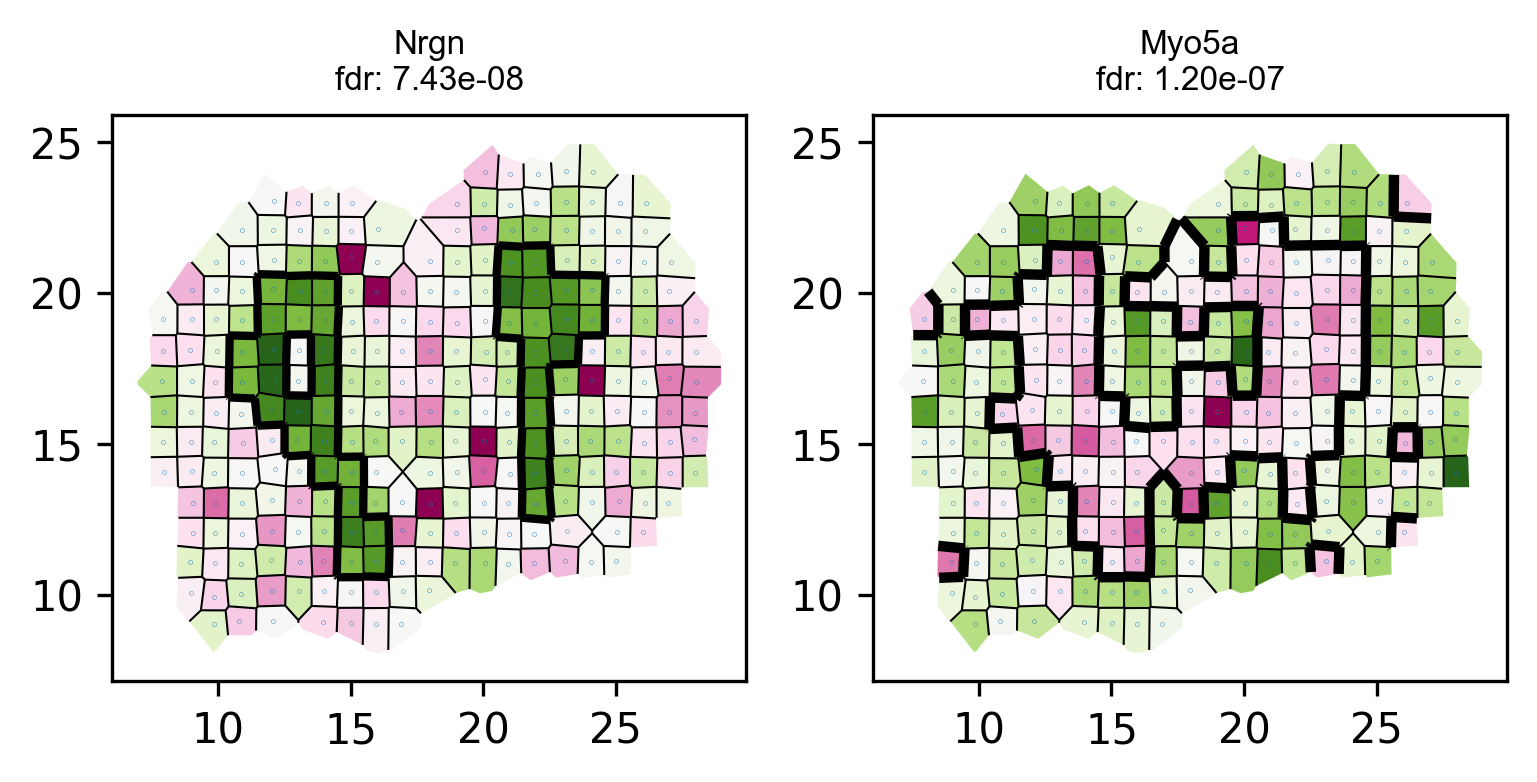

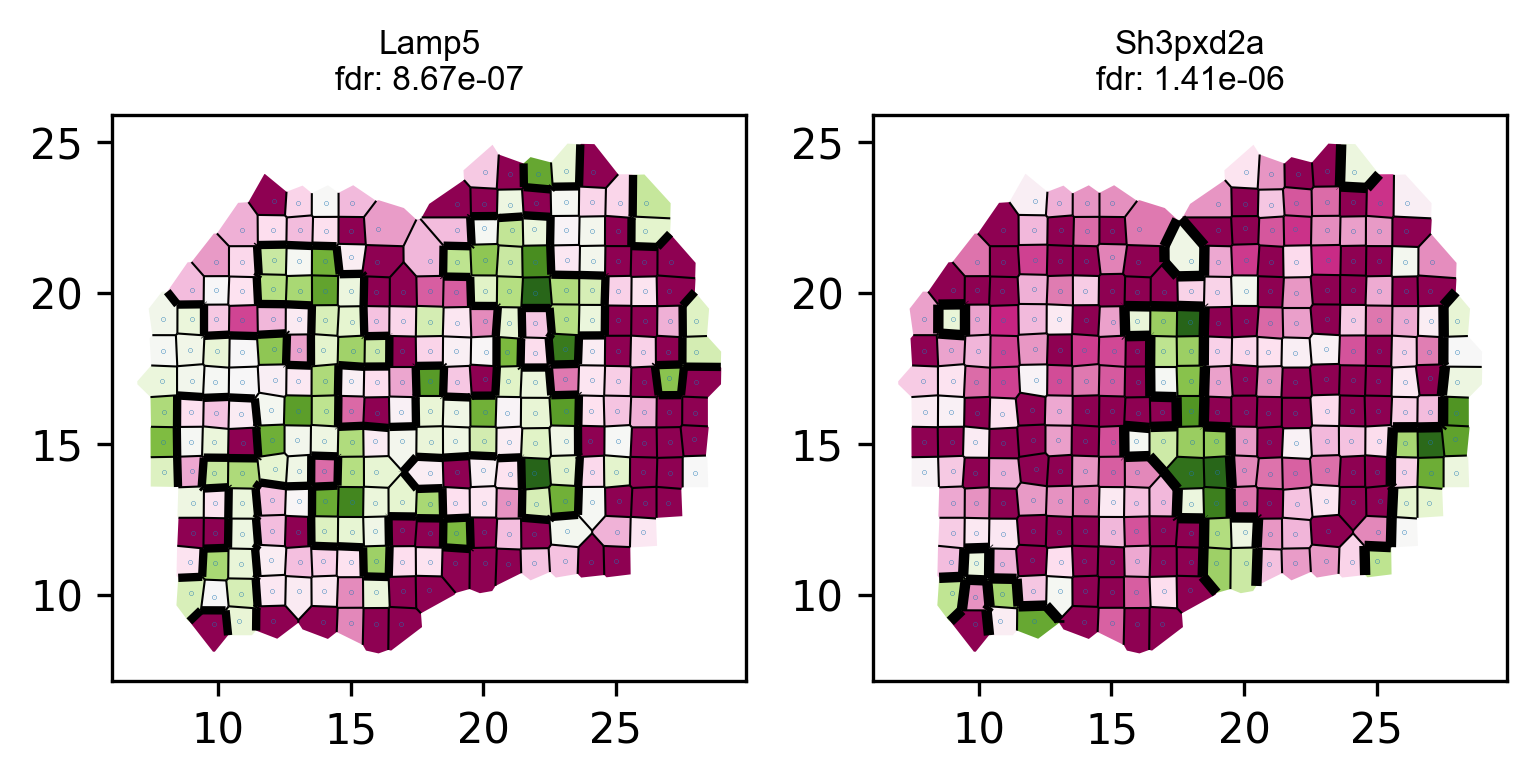

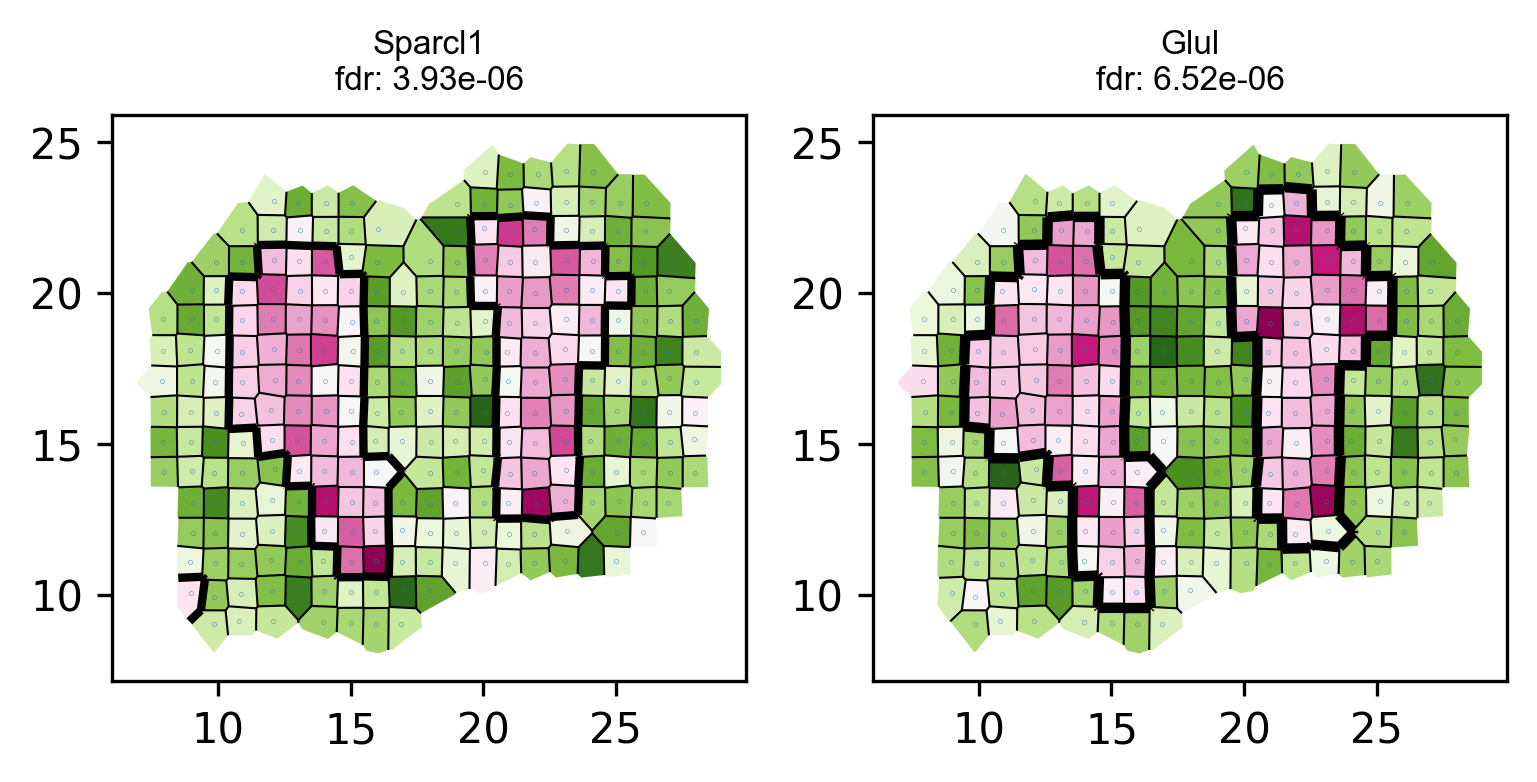

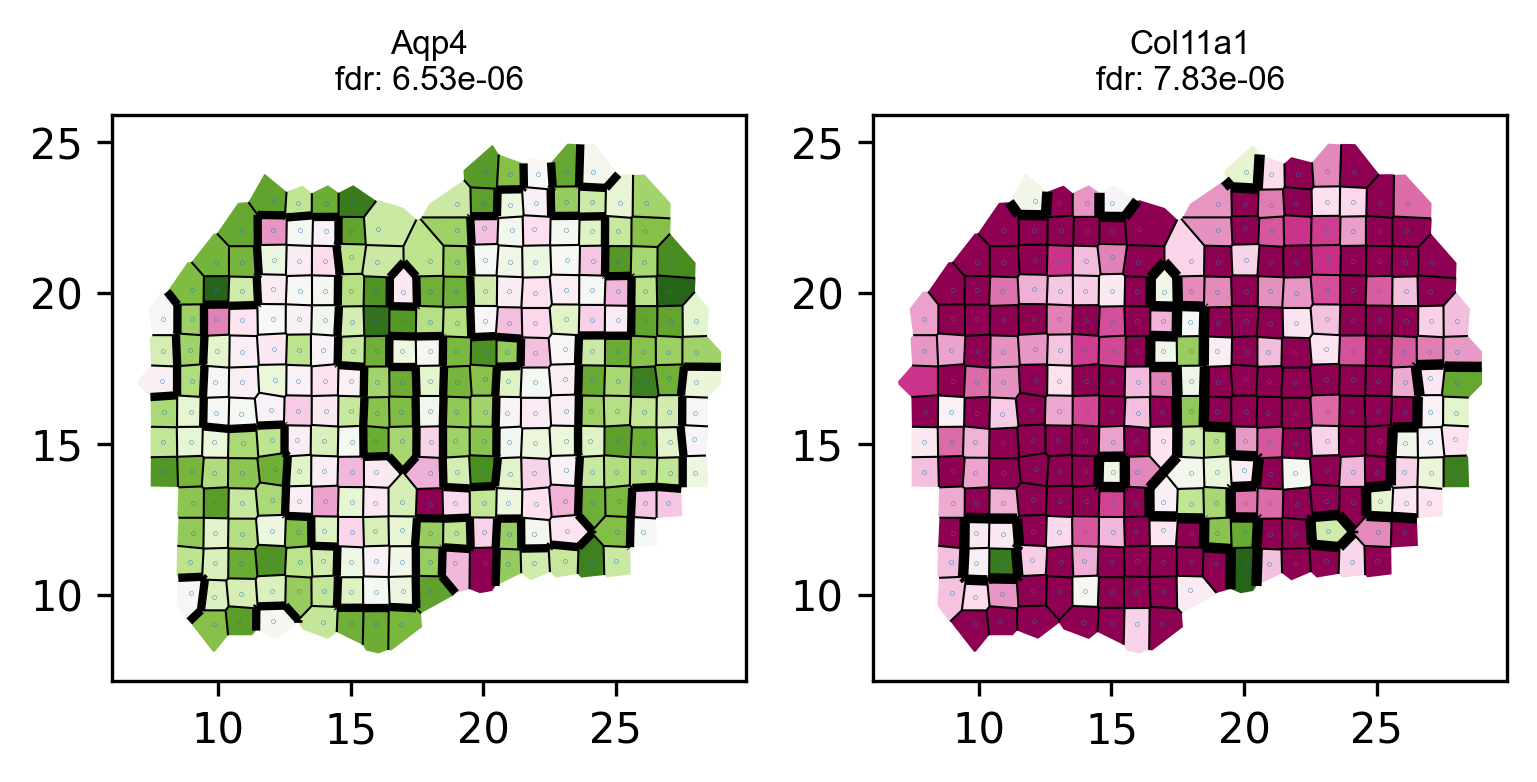

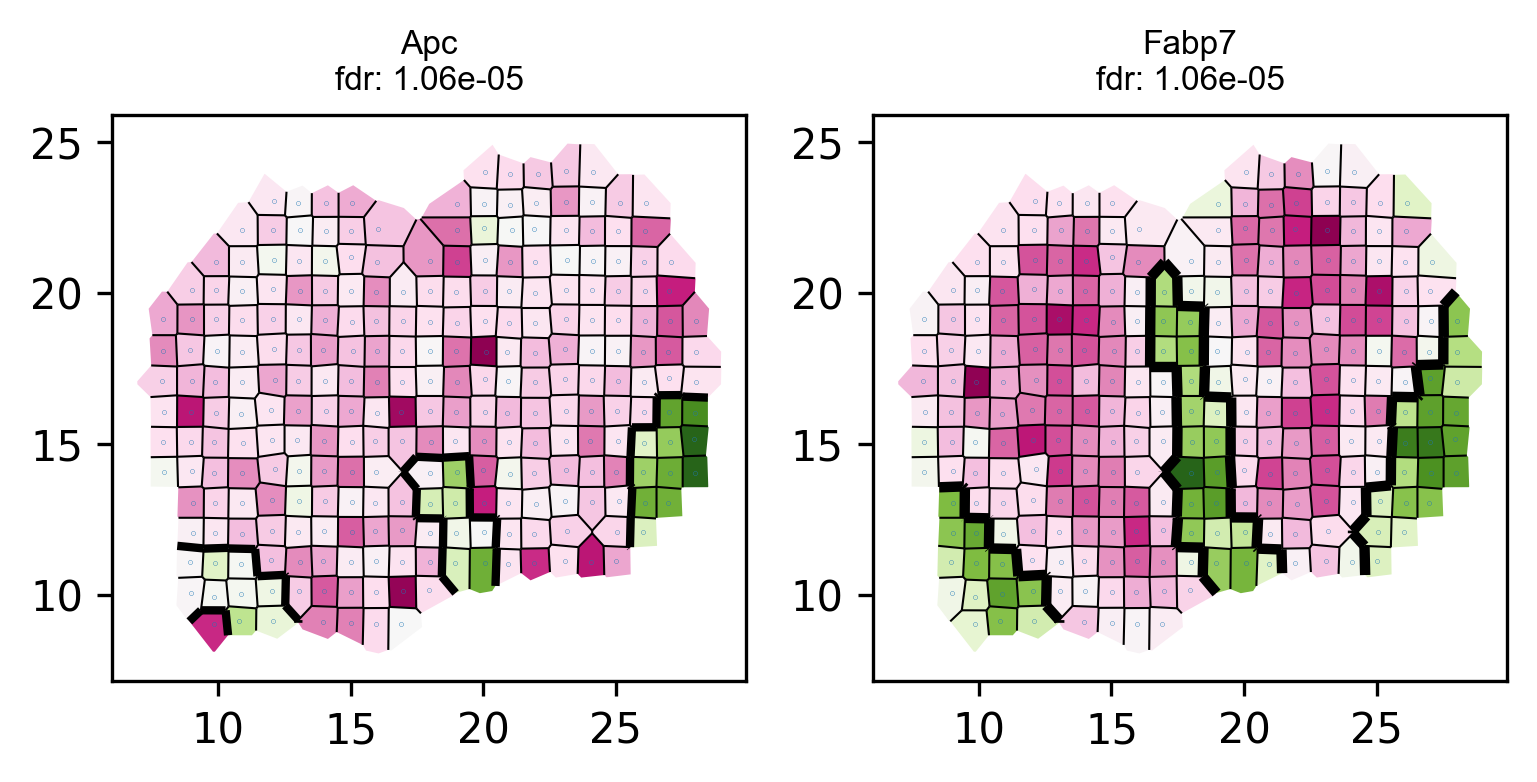

In [12]:
# visualize top genes
visualize_spatial_genes(fdr_df.iloc[0:10,], locs, data_norm ,point_size=0.2)


In [14]:
# save top genes to pdf
multipage_pdf_visualize_spatial_genes(fdr_df.iloc[0:10,], locs, data_norm, cellGraph, point_size=0,
                                      fileName='../../results/Figure//top10_genes.pdf')

## **Step 6:** 
<br><font size=4> **Perform t-SNE and visualize the clustering of identified genes.**<font>

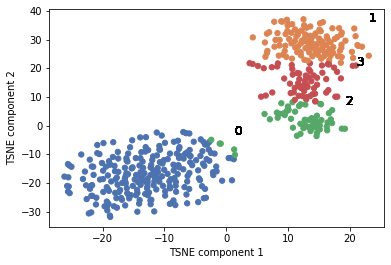

In [16]:
marker_genes = ['Pcp4','Apod','Slc17a7','Glul']
tsne_proj_df = spatial_pca_tsne_kmeans_cluster_gene(data_norm_new, 
                                                    fdr_df.index,
                                                    marker_genes, 
                                                    perplexity = 30,
                                                    fileName=None)
# plot_tsne(tsne_proj_df.iloc[:,0:2].values,tsne_proj_df.iloc[:,2]) #,
#           fileName='../../PDF_file/supple_figure/Fig2b.pdf')

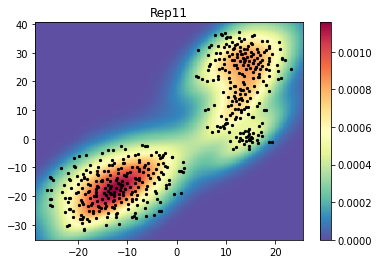

In [18]:
fig,ax = plt.subplots()
title = 'Rep'+str(j)
zz=visualize_tsne_density(tsne_proj_df.iloc[:,0:2].values,title=title,bins=200,threshold=0.1,ax=ax,fig=fig)

## **Step 7:** 

<br><font size=4>**Perform graph cuts for a single gene.**<font>

raw data dim: (262, 16218)
Number of expressed genes a spot must have to be kept (0.01% of total expressed genes) 3375
Marked 3 spots
Removing genes that are expressed in less than 3 spots with a count of at least 1
Dropped 1559 genes


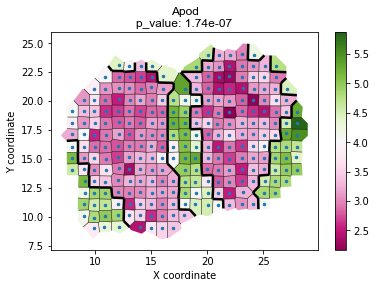

In [25]:
# You can also analyze one gene of interest

geneID='Apod' # Lets use Nrgn as an example
unary_scale_factor = 100 # scale factor for unary energy, default value works well
label_cost=10
algorithm='expansion'
# set smooth factor to 20 for example; 
# use bigger smooth_factor to get less segments
# use small smooth_factor to get more segments
smooth_factor=20 

ff = '../../data/Raw_data/MOB-breast_cancer/Rep11_MOB_count_matrix-1.tsv' 
# read in spatial gene expression data
locs, data, _ = read_spatial_expression(ff,sep='\t')

# normalize gene expression
data_norm = normalize_count_cellranger(data)

# select anyone gene's expression
exp =  data_norm.iloc[:,0]

# create graph representation of spatial coordinates of cells
cellGraph = create_graph_with_weight(locs, exp)

        
# GMM 
count = data_norm.loc[:,geneID].values
gmm=perform_gmm(count)

# do graph cut
temp_factor=smooth_factor
newLabels, label_pred = cut_graph_general(cellGraph, count, gmm, unary_scale_factor, 
                                        temp_factor, label_cost, algorithm)
    
# calculate p values
p, node, com = compute_p_CSR(locs, newLabels, gmm, count, cellGraph)

# Visualize graph cut results
plot_voronoi_boundary(geneID, locs, count,  newLabels, min(p)) 

# save the graph cut results to pdf
# pdf_voronoi_boundary(geneID, locs, count, newLabels, min(p), 
#                    fileName=None, #  '../../results//{}.pdf'.format(geneID),
#                     point_size=0)
